In [196]:
# To use this notebook, you need to create a txt file which contains 
# the output results of xspec commands:{show free,show fit,error},
# and you should paste the 'error' results of *all* parameters.

# based on XSPEC version: 12.12.1, Not compatible with older versions! 

In [197]:
%reset -f
import numpy as np
import imp
import os
import math

In [198]:
# variables
#relxill_v.2.0
relxill_family = ['relconv','relconv_lp'
                  'relxill','relxillCp',
                  'relxilllp','relxilllpCp',
                  'relline','relline_lp',
                  'relxillNS',
                  'xillver','xillverCp',
                  'xillverD',
                  'xillverNS']
#relxill_nk_v.1.6.3
relxill_nk_family = ['relxill_nk','relxillCp_nk',
                     'relxill_nk2',
                     'relxillD_nk',
                     'relline_nk',
                     'rellinedisk_nk',
                     'rellinelp_nk',
                     'rellinering_nk',
                     'relxilllp_nk','relxilllpCp_nk',
                     'relxilllpD_nk'
                     'relxilldgrad_nk',
                     'relxilldisk_nk',
                     'relxillion_nk','relxillionCp_nk',
                     'relxilllpion_nk','relxilllpionCp_nk',
                     'relxillring_nk']
#combine
rel_family = ['relconv','relconv_lp',
              'relxill','relxillCp','relxill_nk','relxillCp_nk','relxill_nk2',
              'relxilllp','relxilllpCp','relxilllp_nk','relxilllpCp_nk',
              'relxilllpD_nk',
              'relline','relline_nk','rellinedisk_nk',
              'relline_lp','rellinelp_nk',
              'rellinering_nk',
              'relxilldgrad_nk',
              'relxilldisk_nk',
              'relxillNS',
              'relxillD_nk',
              'relxillion_nk','relxillionCp_nk',
              'relxilllpion_nk','relxilllpionCp_nk',
              'relxillring_nk'
              'xillver','xillverCp',
              'xillverD',
              'xillverNS']

def add_something(strs:list,add:str):
    new_strs = []
    for str in strs:
        new_strs.append(add+'_'+str)
    return new_strs
#norm    
norm_rel = add_something(rel_family,'norm')
norm_2_rel = add_something(rel_family,'norm_2')
norm_3_rel = add_something(rel_family,'norm_3')
norm_4_rel = add_something(rel_family,'norm_4')
norm_rel_total = norm_rel + norm_2_rel + norm_3_rel + norm_4_rel
#logxi
logxi_xill = add_something(rel_family,'logxi')
logxi_2_xill = add_something(rel_family,'logxi_2')
logxi_3_xill = add_something(rel_family,'logxi_3')
logxi_4_xill = add_something(rel_family,'logxi_4')
logxi_xill_total = logxi_xill + logxi_2_xill + logxi_3_xill + logxi_4_xill
# print(logxi_xill)

In [199]:
factor = ['factor_1','factor_2','factor_3','factor_4']
dGamma = ['dGamma_1','dGamma_2','dGamma_3','dGamma_4']
crabcorNorm = ['crabcorNorm_1','crabcorNorm_2','crabcorNorm_3','crabcorNorm_4']

In [200]:
#function may need to check or modify:
#you need check if all the parameters strings are in the *parameters lib* in the function "sort_parameters"
#if not, you should add them to "sort_parameters" and their respective latex strings in the function "get_latex_of_parameters"
def sort_parameters(key_origin,debug=False):
    #在此函数中设定表格中参数的顺序，根据需求修改
    #创建一个字典，键是序列keys里的元素，值是对应的latex字符串
    #需根据实际情况进行扩充或修改。
    if debug == True:
        print('key_origin:')
        print(key_origin)
    parameter_lib = ['MaxTau',#edge
                     'nH',#tbabs
                     'nH_2',#tbabs_2
                     'Tin','Tin_1','Tin_2','Tin_3','Tin_4',
                     'norm_diskbb','norm_1_diskbb','norm_2_diskbb','norm_3_diskbb',#diskbb
                     'Mbh','Mdd','Dbh',#kerrbb
                     'FracSctr','FracSctr_1','FracSctr_2','FracSctr_3','FracSctr_4',#simplcutx
                     'norm_cutoffpl','kT_bb',#nthcomp or cutoffpl
                     'norm_nthComp','norm_1_nthComp','norm_2_nthComp','norm_3_nthComp','norm_4_nthComp',
                     'T0','kT','norm_compTT',#compTT
                     'cov_frac',#thcomp
                     'PhoIndex','PhoIndex_1','PhoIndex_2','PhoIndex_3','PhoIndex_4','Gamma_tau','Gamma','Gamma_1','Gamma_2','Gamma_3','Gamma_4','gamma',#power-law component
                     'kT_e','kTe','Ecut','E_cut','HighECut','HighECut_2','HighECut_3','HighECut_4', #E_cut
                     'h',#lamppost corona
                     'Index1','Index2','Index3','Rbr','Rbr1','Rbr2',#emission profile
                     'Rin',
                     'a',#black hole
                     'Incl','i',#accretion disk
                     'Afe',#abundance
                     'xi_index',#reflection
                     'refl_frac',
                     'logN',
                     'LineE','LineE_2','LineE_3','LineE_4','norm_gaussian','norm_2_gaussian','norm_3_gaussian','norm_4_gaussian','Sigma','Sigma_2','Sigma_3','Sigma_4',#guassian
                     ] + logxi_xill_total + norm_rel_total + factor + dGamma + crabcorNorm
    a = range(len(parameter_lib))
    dict1 = dict(zip(a,parameter_lib))
    if debug == True:
        print('dict1:')
        print(dict1)
    dict2 = dict(zip(parameter_lib,a))
    if debug == True:
        print('dict2:')
        print(dict2)
    key_temp_1 = []
    keys = []
    for i in key_origin:
        key_temp_1.append(dict2.get(i))
    for a in key_temp_1:
        if a == 'None':
            print("you are missing some parameters in 'parameters_lib', please check it in function 'sort_parameters'")
    if debug == True:
        print('key_temp_1:')
        print(key_temp_1)
    key_temp_2 = sorted(key_temp_1)  
    for j in key_temp_2:
        keys.append(dict1.get(j))
    if debug == True:
        print('keys:')
        print(keys)  
    return keys

def get_latex_of_parameters(keys):
    #we need to call another function to determine the output latex for some parameters
    #such as: Index1,2, Rbr(nk or not nk)
    #factor:output without the instrument names, you should fill it by yourself.
    number = len(keys)
    keys_latex = [None]*number
    for i in range(number):
        #edge
        if keys[i] == 'MaxTau':
            keys_latex[i] = '$\\tau_{\\tt max}$'
        #tbabs
        if keys[i] in ['nH','nH_2']:
            keys_latex[i] = '$N_{\\rm H}$ [\\(10^{22}\\) cm\\(^{-2}\\)]'
        #diskbb
        if keys[i] in ['Tin','Tin_1','Tin_2','Tin_3','Tin_4']:
            keys_latex[i] = '$T_{\\rm in}$'
        #kerrbb
        if keys[i] == 'Mbh':
            keys_latex[i] = '$M$'
        if keys[i] == 'Mdd':
            keys_latex[i] = '$\dot M$'
        if keys[i] == 'Dbh':
            keys_latex[i] = '$D$'
        #simplcutx
        if keys[i] in ['FracSctr','FracSctr_1','FracSctr_2','FracSctr_3','FracSctr_4','FracSctr_5']:
            keys_latex[i] = '$f_{\\tt SC}$'
        #nthcomp
        if keys[i] == 'kT_bb':
            keys_latex[i] = '$kT_{bb}$'
        #compTT
        if keys[i] == 'T0':
            keys_latex[i] = '$T_{0}$'
        if keys[i] == 'kT':
            keys_latex[i] = '$T_{plasma}$'
        #thcomp
        if keys[i] == 'cov_frac':
            keys_latex[i] = '$cov_{\\rm frac}$'
        if keys[i] == 'Gamma_tau':
            keys_latex[i] = '$\\Gamma_{\\tau}$'
        #power-law component
        if keys[i] in ['Gamma','Gamma_1','Gamma_2','Gamma_3','Gamma_4','gamma','PhoIndex','PhoIndex_2','PhoIndex_3','PhoIndex_4']:
            keys_latex[i] = '$\\Gamma$'
        if keys[i] in ['kT_e','kTe']:
            keys_latex[i] = '$kT_{\\rm e}$ [keV]'
        if keys[i] in ['E_cut','Ecut','HighECut','HighECut','HighECut_2','HighECut_3','HighECut_4']:
            keys_latex[i] = '$E_{\\rm cut}$'
        #lamppost corona
        if keys[i] == 'h':
            keys_latex[i] = '$h$'
        #emission profiles
        if keys[i] == 'Index1':
            keys_latex[i] = '$q_{\\rm in}$'
        if keys[i] == 'Index2':
            keys_latex[i] = '$q_{\\rm out}$ '
        if keys[i] == 'Index3':
            keys_latex[i] = '$q_{3}$'
        if keys[i] == 'Rbr':
            keys_latex[i] = '$R_{\\rm br}$ [$R_{\\rm g}$]'
        if keys[i] == 'Rbr1':
            keys_latex[i] = '$R_{\\rm br1}$ [$R_{\\rm g}$]'
        if keys[i] == 'Rbr2':
            keys_latex[i] = '$R_{\\rm br2}$ [$R_{\\rm g}$]'
        if keys[i] == 'Rin':
            keys_latex[i] = '$R_{\\rm in}$'
        #black hole
        if keys[i] == 'a':
            keys_latex[i] = '$a_{*}$'
        #accretion disk
        if keys[i] in ['Incl','i']:
            keys_latex[i] = '$i$ [deg]'
        #abundance
        if keys[i] == 'Afe':
            keys_latex[i] = 'A$_{\\rm Fe}$'
        #reflection
        if keys[i] == 'xi_index':
            keys_latex[i] = '$\\alpha_{\\xi}$' 
        if keys[i] == 'refl_frac':
            keys_latex[i] = '$R_{\\rm f}$'
        if keys[i] == 'logN':
            keys_latex[i] = 'log${\\rm N}$'
        #guassian
        if keys[i] in ['LineE','LineE_2','LineE_3','LineE_4']:
            keys_latex[i] = '$E_{\\rm line}$'
        if keys[i] in ['Sigma','Sigma_2','Sigma_3','Sigma_4']:
            keys_latex[i] = '$\\sigma$'
        #norm
        if keys[i].split('_')[0] == 'norm':
            if len(keys[i].split('_')) == 2:
                keys_latex[i] = 'Norm({\\tt ' + keys[i].split('_')[1] + '})'
            else: 
                keys_latex[i] = 'Norm({\\tt ' + keys[i].split('_')[2] + keys[i].split('_')[1] + '})'
        #logxi
        if keys[i].split('_')[0] == 'logxi':
            if keys[i].split('_')[1] in ['2','3','4']:
                keys_latex[i] = 'log${\\xi}$(' + keys[i].split('_')[2] + keys[i].split('_')[1] +')[erg~cm~s$^{-1}$]'
            else:
                keys_latex[i] = 'log${\\xi}$('+ keys[i].split('_')[1] +')[erg~cm~s$^{-1}$]'
        #factor:output without the instrument names, you should fill it by yourself in latex.
        if keys[i].split('_')[0] == 'factor':
            keys_latex[i] = '$C_{\\rm instrument' + keys[i].split('_')[1] + '}$'
        if keys[i].split('_')[0] == 'dGamma':
            keys_latex[i] = '$dGamma_{\\rm instrument' + keys[i].split('_')[1] + '}$'
        if keys[i].split('_')[0] == 'crabcorNorm':
            keys_latex[i] = '$crabcorNorm_{\\rm instrument' + keys[i].split('_')[1] + '}$'
    par_latex = dict(zip(keys,keys_latex))
    return par_latex

In [201]:
# txt file pre-treatment
def do_something2multifiles(infiles:list):
    for infile in infiles:
        delete_hashtag_and_blank_line(infile)
        add_index2par_single_file(infile)
        delete_useless_str(infile)
        mod_nk(infile)
        i2incl(infile)
        show_par2show_free(infile)
    check_Rbr(infiles)
        
def delete_hashtag_and_blank_line(file): 
    # "#"and blank line should be removed first.
    file_data = ""
    with open(file,"r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                if '#' in line:
                    line = line.replace('#','')
                if line == '\n':
                    line = line.strip("\n")           
                file_data += line
    with open(file,"w",encoding="utf-8") as f:
        f.write(file_data) 

def delete_useless_str(file):
    # 请先保证文档没有空行。
    file_data = ""   
    str_delete = ['Apparent','Current','and','but','Suggest',
                  'Error','***','caused','Parameter','***Warning:','Due','Suggest','pparent','Please','will automatically exit']    
    with open(file, "r") as input:
        lines = input.readlines()
        for line in lines:
            if line.split() == []:
                continue
            if line.split()[0] not in str_delete:
                file_data += line   
    with open(file,"w",encoding="utf-8") as output:
        output.write(file_data) 
    
def add_index2par_single_file(infile):
    #example: factor -> factor_2; factor -> factor_3
    #example: nH -> nH_2
    file_data = ""
    index = ''
    with open(infile, "r", encoding="utf-8") as f:
        lines = f.readlines()
        for i in range(len(lines)):
            if len(lines[i].split()) < 3:
                continue
            elif lines[i].split()[0] == 'Data' and lines[i].split()[2] != '1':
                #第零行:数据组标题
                index = lines[i].split()[2]
                #第一行
                factor = lines[i+1].split()[3]
                if factor == 'factor':
                    #if not, it means that it have already been changed
                    lines[i+1] = lines[i+1].replace('factor','factor'+'_'+index)
                if factor == 'dGamma':
                    #if not, it means that it have already been changed
                    lines[i+1] = lines[i+1].replace('dGamma','dGamma'+'_'+index)
                if factor == 'Tin':
                    lines[i+1] = lines[i+1].replace('Tin','Tin'+'_'+index)
                if factor == 'FracSctr':
                    lines[i+1] = lines[i+1].replace('FracSctr','FracSctr'+'_'+index)
                if factor == 'PhoIndex':
                    lines[i+1] = lines[i+1].replace('PhoIndex','PhoIndex'+'_'+index)
                #第二行
                if len(lines[i+2].split()) > 3:
                    factor2 = lines[i+2].split()[3]
                    if factor2 == 'nH':
                    #if not, it means that it have already been changed
                        lines[i+2] = lines[i+2].replace('nH','nH'+'_'+index)
                    if factor2 == 'crabcorNorm':
                    #if not, it means that it have already been changed
                        lines[i+2] = lines[i+2].replace('crabcorNorm','crabcorNorm'+'_'+index)
                    if factor2 == 'norm':
                    #if not, it means that it have already been changed
                        lines[i+2] = lines[i+2].replace('norm','norm'+'_'+index)
                    if factor2 == 'Tin':
                        lines[i+2] = lines[i+2].replace('Tin','Tin'+'_'+index)
                    if factor2 == 'HighECut':
                        lines[i+2] = lines[i+2].replace('HighECut','HighECut'+'_'+index)
                #第三行
                if len(lines[i+3].split()) > 3:
                    factor3 = lines[i+3].split()[3]
                    if factor3 == 'Tin':
                    #if not, it means that it have already been changed
                        lines[i+3] = lines[i+3].replace('Tin','Tin'+'_'+index)
                    if factor3 == 'FracSctr':
                        lines[i+3] = lines[i+3].replace('FracSctr','FracSctr'+'_'+index)
                #第四行
                if len(lines[i+4].split()) > 3:
                    factor4 = lines[i+4].split()[3]
                    if factor4 == 'norm':
                    #if not, it means that it have already been changed
                        lines[i+4] = lines[i+4].replace('norm','norm'+'_'+index)
                    if factor4 == 'Tin':
                        lines[i+4] = lines[i+4].replace('Tin','Tin'+'_'+index)  
                    if factor4 == 'Gamma':
                        lines[i+4] = lines[i+4].replace('Gamma','Gamma'+'_'+index)   
                #第五行      
                if len(lines[i+5].split()) > 3:
                    factor5 = lines[i+5].split()[3]
                    if factor5 == 'logxi':
                    #if not, it means that it have already been changed
                        lines[i+5] = lines[i+5].replace('logxi','logxi'+'_'+index)    
                #第六行      
                if len(lines[i+6].split()) > 3:
                    factor6 = lines[i+6].split()[3]
                    if factor6 == 'norm':
                    #if not, it means that it have already been changed
                        lines[i+6] = lines[i+6].replace('norm','norm'+'_'+index) 
                #第七行
                if len(lines[i+7].split()) > 3:
                    factor7 = lines[i+7].split()[3]
                    if factor7 == 'LineE':
                    #if not, it means that it have already been changed
                        lines[i+7] = lines[i+7].replace('LineE','LineE'+'_'+index) 
                #第八行
                if len(lines[i+8].split()) > 3:
                    factor8 = lines[i+8].split()[3]
                    if factor8 == 'Sigma':
                    #if not, it means that it have already been changed
                        lines[i+8] = lines[i+8].replace('Sigma','Sigma'+'_'+index) 
                #第九行
                if len(lines[i+9].split()) > 3:
                    factor9 = lines[i+9].split()[3]
                    if factor9 == 'norm':
                    #if not, it means that it have already been changed
                        lines[i+9] = lines[i+9].replace('norm','norm'+'_'+index) 
        for line in lines:
            file_data += line
    with open(infile, "w", encoding="utf-8") as f: 
        f.write(file_data)      

def mod_nk(file):
    #因为nk后缀会破坏按行切分
    # 替换文件中的字符串,把rexill_nk的后缀nk去掉。这个函数对需要把relxill和relxill_nk放在同一行比较时才有用。
    file_data = ""
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.replace('_nk','_nk ')
            line = line.replace('relxilllpCp','relxilllpCp ')
            file_data += line
    with open(file,"w",encoding="utf-8") as f:
        f.write(file_data) 
           
def check_Rbr(files:list):
    #first, make a judgement and decide whether to replace 'Rbr' with 'Rbr_1'
    a = 0
    for file in files:
        with open(file, "r", encoding=" utf-8") as f:
            lines = f.readlines()
            for line in lines:
                if 'Rbr_2' in line.split():
                    a += 1
    if a > 0:        
        for file in files:
        # 替换文件中的字符串,把Rbr替换为Rbr_1。这是因为我们需要把relxill和relxill_nk放在同一行比较时才有用。
            file_data = ""
            with open(file, "r", encoding="utf-8") as f:
                for line in f:
                    if ('Rbr' in line) and ('Rbr1' not in line) and ('Rbr2' not in line):
                        line = line.replace('Rbr','Rbr1')
                    file_data += line
            with open(file,"w",encoding="utf-8") as f:
                f.write(file_data)
                f.close()  
                
def i2incl(file):
    file_data = ""
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            if len(line.split()) < 4:
                file_data += line
            else:
                if line.split()[3] == 'i':
                    line = line.replace('i','Incl')
                file_data += line
    with open(file,"w",encoding="utf-8") as f:
        f.write(file_data)     
          
def show_par2show_free(file):
    #get error list
    error_list = []
    with open(file,"r", encoding="utf-8") as f:
        for line in f:
            if len(line.split()) == 4:
                if len(line.split()[-1].split(',')) == 2:
                    error_list.append(line.split()[0])
    #read show par and copy some fo them
    file_data = ""
    start_index = 0
    end_index = 0
    with open(file,"r", encoding="utf-8") as f:
        for x in enumerate(f):
            line = x[1]
            if len(line.split()) > 1:
                if line.split()[0] == 'par' and line.split()[1] == 'comp':
                    start_index = int(x[0]) + 2
    with open(file,"r", encoding="utf-8") as f:               
        for x in enumerate(f):
            line = x[1]
            if len(line.split()) > 1:
                if line.split()[0] == 'Fit':
                    end_index = int(x[0]) - 1
    with open(file,"r", encoding="utf-8") as f:
        for x in enumerate(f):
            copy = True
            index = x[0]
            line = x[1]
            if index >= start_index and index <= end_index:
                if len(line.split()) > 1:
                    if line.split()[0] == 'Data':
                        copy = True
                    elif line.split()[0] in error_list:
                        copy = True
                    else:
                        copy = False        
                else:
                    copy = True
            else:
                copy = True     
            if copy == True:
                file_data += line
    #write down the new file
    with open(file,"w",encoding="utf-8") as f:
        f.write(file_data)            

In [202]:
#get parameters values from the data
def get_par_best_error(infile):
    
    index = []
    parameter = []
    best_fit = []
    bound = []
    data_group_index = ''
    
    f = open(infile, 'r')
    lines = f.readlines()
    
    for line in lines:
        if len(line.split())>4: 
            if line.split()[-2] == '+/-':
                if (line.split()[3] in ['norm','norm_1','norm_2','norm_3','norm_4'] or line.split()[3] in ['logxi','logxi_2','logxi_3','logxi_4']):
                    index.append(line.split()[0])
                    parameter.append(line.split()[3] + "_" + line.split()[2])
                    #example: 'norm' + '_' + 'nthcomp'
                else:
                    index.append(line.split()[0])
                    parameter.append(line.split()[3])
    parameters = dict(zip(index,parameter))
    
    
    for line in lines:
        if len(line.split())>4: 
            if line.split()[-2] == '+/-':
                index.append(line.split()[0])
                best_fit.append(line.split()[-3])
    best = dict(zip(index,best_fit)) 
    
    
    for line in lines:
        if len(line.split())>3:
            if line.split()[-1][-1]==")":
                if len(line.split()[-1].split(','))>1.1:
                    index.append(line.split()[0])
                    bound.append([line.split()[1], line.split()[2]])
                    
    bounds = dict(zip(index,bound))
    
    
    f.close()
    
    return parameters, best, bounds

In [203]:
#get latex elements
def get_latex_elements_single_file(infile,debug=False):
    import imp
    import error2latex as el
    imp.reload(el)
    
    parameter, best_fit, bounds = get_par_best_error(infile)
    
    #index = []
    par = []
    latex_c = []
    
    if len(best_fit)!=len(bounds):
        print("Error: best-fit parameters do not match the number of uncertainties")
        print(f"Number of free parameters: {len(best_fit)}, number of boundaries: {len(bounds)}")
    
    for key in best_fit.keys():
        name = parameter[key]
        best = best_fit[key]
        lower = bounds[key][0]
        upper = bounds[key][1]
        string, value_base, err_low_base, err_high_base = el.get_xspec_error(best, lower, upper) 
        
        #index.append(key)
        par.append(name)
        latex_c.append(string)    
        
       # print(string)
    #result = dict(zip(index,latex_c))
    # print(par)
    result = dict(zip(par,latex_c))
    if debug == True:
        print('Hey! latex elements have been got from ' + infile)
    
    return result

def get_latex_elements_multiple_file(infiles,debug=False):
    number = len(infiles)
    elements = [None]*number
    for i in range(number):
        if debug == False:
            elements[i] = get_latex_elements_single_file(infiles[i])
        else:
            elements[i] = get_latex_elements_single_file(infiles[i],debug=True)
    pars = []
    
    for i in range(number):
        pars = pars + list(elements[i].keys())
    keys_origin = list(set(pars))
    
    if debug == True:
        keys = sort_parameters(keys_origin,debug=True)
    else:
        keys = sort_parameters(keys_origin)
        
    return elements, keys

In [204]:
#get statistics values and its latex code
def get_chi_sq_and_AICc_single_file(infile):
# based on XSPEC version: 12.12.1, not Not compatible with older versions! 
# because the xspec outputs of "show fit" are different in version: 12.12.1 
    
    f = open(infile, 'r')
    lines = f.readlines()
    
    index = ['chisq','dof','reduced_chisq','N-bin','N-par','AICc']
    value = [None]*6
    
    for line in lines:
        if line.split()[0] == 'Test' and line.split()[-1] == 'bins.':
            value[3] = int(line.split()[-2])
    
    for line in lines:
        if len(line.split())>4:
            if line.split()[-1] == 'd.o.f.':
                value[0] = float(line.split()[3])
                value[1] = int(line.split()[-2])
                value[2] = float("{:.5f}".format(value[0] / value[1]))

    value[4] = value[3] - value[1]
    
    value[5] = float("{:.2f}".format(value[0] + 2*value[4] + 2*value[4]*(value[4]+1)/(value[3]-value[4]-1)))
    
    result = dict(zip(index,value))
    
#     print('got statistic from ' + infile)
    
    return result

def print_chi_sq_and_AICc_multiple_files(infiles, outfile):
    
    number = len(infiles)
    chisq, dof, reduced_chisq, AICc = [None]*number, [None]*number, [None]*number, [None]*number
    for i in range(number):
        chisq[i] = get_chi_sq_and_AICc_single_file(infiles[i]).get('chisq')
        dof[i] = get_chi_sq_and_AICc_single_file(infiles[i]).get('dof')
        reduced_chisq[i] = get_chi_sq_and_AICc_single_file(infiles[i]).get('reduced_chisq')
        AICc[i] = get_chi_sq_and_AICc_single_file(infiles[i]).get('AICc')

    string = '$\chi^2$ /dof'
    
    string_AICc = 'AICc'
    
    for n in range(number):
        string = string + ' & ' +'\\tabincell{c}{' + str(chisq[n]) + '/' + str(dof[n]) + '=\\\\' + str(reduced_chisq[n]) + '}'
        string_AICc = string_AICc + ' & ' + str(AICc[n])
        
    print('\\hline' + '\n\n' + string + '\\\\' + '\n\n' + string_AICc +  '\\\\' + '\n\n' + '\\hline' + '\n', file=outfile)

In [205]:
#finally,print the full latex code
def print_final_latex_code(infiles:list,model_name:list,debug=False,output_filename='latex_table_output.txt'):
    # Open the file for writing
    output_file = open(output_filename, "w")
        
    do_something2multifiles(infiles)
    if debug == True:
        elements, keys = get_latex_elements_multiple_file(infiles,debug=True)
    else:
        elements, keys = get_latex_elements_multiple_file(infiles)
    #去掉多余的减号
    for i in range(len(infiles)):
        for key in elements[i].keys():
            elements[i][key] = elements[i][key].replace('{--','{-')
    if debug == True:
        print('elements: ')
        print(elements)
    
    par_latex = get_latex_of_parameters(keys)
    # print(par_latex)
    
    # newcommand reminder:
    
    print("please copy this to the front of your .tex file in order to use commands:'tabincell':\n", file=output_file)
    print("\\newcommand{\\tabincell}[2]{\\begin{tabular}{@{}#1@{}}#2\\end{tabular}}\n", file=output_file)
    
    print("###########################################################################################################################", file=output_file)
    
    #resizebox or not
    if len(infiles) > 5:
        print('\n'+'%please copy this line to the front of your .tex document in order to use \\tabincell: '+ '\n'
              +'\\newcommand{\\tabincell}[2]{\\begin{tabular}{@{}#1@{}}#2\\end{tabular}}' + '\n', file=output_file)
        
        print("###########################################################################################################################", file=output_file)
        
        print('\\begin{table*}' + '\n' + '\\centering' + '\n' + '\\renewcommand\\arraystretch{1.5}' + '\n' 
              + '\\caption{}' + '\n' + '\\label{}' + '\n' + '\\resizebox{\\textwidth}{70mm}{' , file=output_file)
    else:
        print('\\begin{table*}' + '\n' + '\\centering' + '\n' + '\\renewcommand\\arraystretch{1.5}' + '\n' 
              + '\\caption{}' + '\n' + '\\label{}' + '\n', file=output_file)
    #table
    chart = '' 
    for i in range(len(infiles)):
        chart += 'c'

    print('\\begin{tabular}{l' + chart + '}'+ '\n', file=output_file)
    
    print('\\hline' + '\n', file=output_file)
    
    model = 'Model'
    for i in range(len(infiles)):
        model += (' & ' + 'Model ' + model_name[i])
    
    print(model + '\\\\' + '\n', file=output_file)
    
    print('\\hline' + '\n', file=output_file)
    
    for par in keys:
        string = par_latex.get(par)
        for n in range(len(infiles)):
            if par in set(list(elements[n].keys())):
    #                 print(string)
                string = string + ' & '+ elements[n][par]
            else:
                string = string + ' & ' + ' - '
        print(string + '\\\\' + '\n', file=output_file)

    print_chi_sq_and_AICc_multiple_files(infiles, output_file)
    
    #print AICc
    
    if len(infiles) > 5:
        print('\\end{tabular}' + '\n' + '}' + '\n' + '\\end{table*}', file=output_file)
    else:
        print('\\end{tabular}' + '\n' + '\n' + '\\end{table*}', file=output_file)
    # Close the file
    output_file.close()

In [206]:
#get txt_file list
path = './'
dirs = os.listdir(path)
txt_files = []
for name in dirs:
    if name.split('.')[-1] == 'txt':
        txt_files.append(name)
print(txt_files)

['relxill_4g_pl-eemod-delchi_100-200.txt', 'relxill_pl-delchi_50-200.txt', 'relxillion-nk_pl-delchi_250-200.txt', 'relxillion-nk_pl-delchi_50-200.txt', 'relxillion-nk_4g_best-fit.txt', 'latex_table_output.txt', 'relxill_4g_pl-eemod-delchi.txt', 'relxill+guassian_4g_pl-eemod-delchi_100-200.txt', 'relxillion-nk_4g_pl-eemod-delchi_100-200.txt', 'relxillion-nk_pl-eemod-delchi.txt', 'relxill_pl-eemod-delchi_250-200.txt', 'relxill_pl-delchi_100-200.txt', 'relxill_4g_best-fit.txt', 'relxill_pl-eemod-delchi.txt', 'relxillion-nk_pl-delchi_100-200.txt', 'relxill_pl-delchi_250-200.txt', 'relxillion-nk_pl-eemod-delchi_250-200.txt', 'relxill+guassian_4g_best-fit.txt', 'relxillion-nk_pl-eemod-delchi_200-200.txt', 'relxill_pl-eemod-delchi_200-200.txt']


In [207]:
# type your txt files list:
# infiles = ['relionCp-nk_best-fit.txt','relionCp-nk_q2-3_best-fit.txt','relionCp-nk+xillcp_logxi-0_best-fit.txt',
#            'simp_disk+relionCp-nk_q2-free_best-fit.txt','mo_2B-1.txt','simp_disk+relionCp-nk_+xillcp_q2-free_best-fit.txt']
# model_name = ['1A','1B','1C','2A','2B','2C']
infiles = ['relxill_4g_best-fit.txt',
           'relxill+guassian_4g_best-fit.txt',
           'relxillion-nk_4g_best-fit.txt']
model_name = ['relxill','+guassian','relxillion-nk']

print_final_latex_code(infiles,model_name,debug=True,output_filename='latex_table_output.txt')

Hey! latex elements have been got from relxill_4g_best-fit.txt
Hey! latex elements have been got from relxill+guassian_4g_best-fit.txt
Hey! latex elements have been got from relxillion-nk_4g_best-fit.txt
key_origin:
['Index1', 'LineE_3', 'xi_index', 'norm_diskbb', 'PhoIndex', 'norm_3_gaussian', 'Rbr1', 'norm_3_relxillion_nk', 'factor_2', 'Tin_3', 'Index2', 'Sigma', 'factor_4', 'nH', 'norm_3_relxill', 'Rbr', 'norm_relxill', 'PhoIndex_3', 'Tin', 'norm_gaussian', 'norm_relxillion_nk', 'HighECut_3', 'logxi_relxill', 'norm_cutoffpl', 'norm_3_diskbb', 'Afe', 'a', 'logxi_3_relxillion_nk', 'LineE', 'logxi_3_relxill', 'logxi_relxillion_nk', 'Sigma_3', 'Incl', 'HighECut']
dict1:
{0: 'MaxTau', 1: 'nH', 2: 'nH_2', 3: 'Tin', 4: 'Tin_1', 5: 'Tin_2', 6: 'Tin_3', 7: 'Tin_4', 8: 'norm_diskbb', 9: 'norm_1_diskbb', 10: 'norm_2_diskbb', 11: 'norm_3_diskbb', 12: 'Mbh', 13: 'Mdd', 14: 'Dbh', 15: 'FracSctr', 16: 'FracSctr_1', 17: 'FracSctr_2', 18: 'FracSctr_3', 19: 'FracSctr_4', 20: 'norm_cutoffpl', 21: 'kT_

to be continued: issue:                           
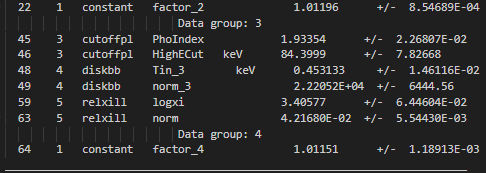